## Notebook setup

In [1]:
library(tidyverse)
library(arcadiathemeR)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading Suisse fonts...



All custom fonts 'Suisse Int'l, Suisse Int'l Semi Bold, Suisse Int'l Medium, Suisse Int'l Mono' are successfully loaded.


In [2]:
setwd("..")

In [3]:
# adjust plot size rendered inline
options(repr.plot.width = 12.72, repr.plot.height = 5, repr.plot.res = 200)

## Plotting constants

In [4]:
LIME <- c("#97CD78")
DRAGON <- c("#C85152")
BARK <- c("#8F8885")
BLACK <- c("#09090A")

REGULAR_FONT <- "Suisse Int'l"
CATEGORICAL_FONT <- REGULAR_FONT

# Read in files

In [9]:
metadata <- read_tsv("benchmarking_data/controls/control_metadata.tsv", show_col_types = FALSE) %>%
  mutate(structure_file = str_remove(string = structure_file, pattern = ".pdb")) %>%
  select(structure_file, target_uniprot, plot_names) %>%
  distinct()

In [10]:
results <- read_csv("outputs/human/selected_mimics/gmmviro3d_benchmarking042925_detailed.csv", show_col_types = FALSE) %>%
  mutate(source_key = str_remove(string = source_key, pattern = ".tsv$")) %>%
  separate(col = source_key, into = c("control", "tool", "alignment_type",
                                      "tmalign_fast", "exact_tmscore",
                                      "tmscore_threshold"),
           sep = "_", remove = FALSE) %>%
  mutate(alignment_type = str_remove(string = alignment_type, pattern = "alignmenttype"),
         tmalign_fast = str_remove(string = tmalign_fast, pattern = "tmalignfast"),
         exact_tmscore = str_remove(string = exact_tmscore, pattern = "exacttmscore"),
         tmscore_threshold = as.numeric(str_remove(string = tmscore_threshold, pattern = "tmscorethreshold"))) %>%
  select(-tmscore_threshold) %>%
  mutate(alignment_type = ifelse(alignment_type == "1", "TM-align", "3Di+AA"),
         tmalign_fast = ifelse(alignment_type == "3Di+AA", "none", tmalign_fast),
         model_type = ifelse(alignment_type == "3Di+AA", "3Di+AA", 
                             ifelse(alignment_type == "TM-align" & grepl(pattern = "evalue", x = feature_set), "hybrid", "TM-align"))) %>%
  left_join(metadata, by = c("query" = "structure_file")) %>%
  mutate(correct = ifelse(target == target_uniprot, "correct hit", "off-target hit"),
         correct = ifelse(is.na(correct), "unknown correct hit", correct),
         # fix c1l correct or incorrect labeling
         correct = ifelse(control == "c1l" & (target == "Q8WXC3" | target == "P10415"), "correct hit", correct))

## Plot figure S1

In [11]:
hit_counts <- results %>%
  group_by(plot_names, model_type, correct) %>%
  summarise(n = n(), .groups = "drop") %>%
  # backfill empty combinations of plot_names and model_type, bc some had no hits
  # so don't appear
  complete(plot_names, model_type, correct, fill = list(n = 0)) %>%
  pivot_wider(names_from = correct, values_from = n, values_fill = 0)

In [13]:
num_correct <- read_tsv("benchmarking_data/controls/control_metadata.tsv", show_col_types = FALSE) %>%
  select(plot_names, target_uniprot) %>%
  mutate(across(where(is.character), str_trim)) %>%
  group_by(plot_names, target_uniprot) %>% 
  tally() %>%
  filter(!is.na(target_uniprot)) %>%
  select(plot_names, num_possible_correct = n)

In [14]:
hit_counts <- hit_counts %>% 
  left_join(num_correct, by = "plot_names") %>%
  mutate(`missed hit` = num_possible_correct - `correct hit`)

In [15]:
hit_counts_long <- hit_counts %>%
  select(-num_possible_correct) %>%
  pivot_longer(cols = c("correct hit", "off-target hit", "unknown correct hit", "missed hit"),
               names_to = "hit_type", values_to = "count")

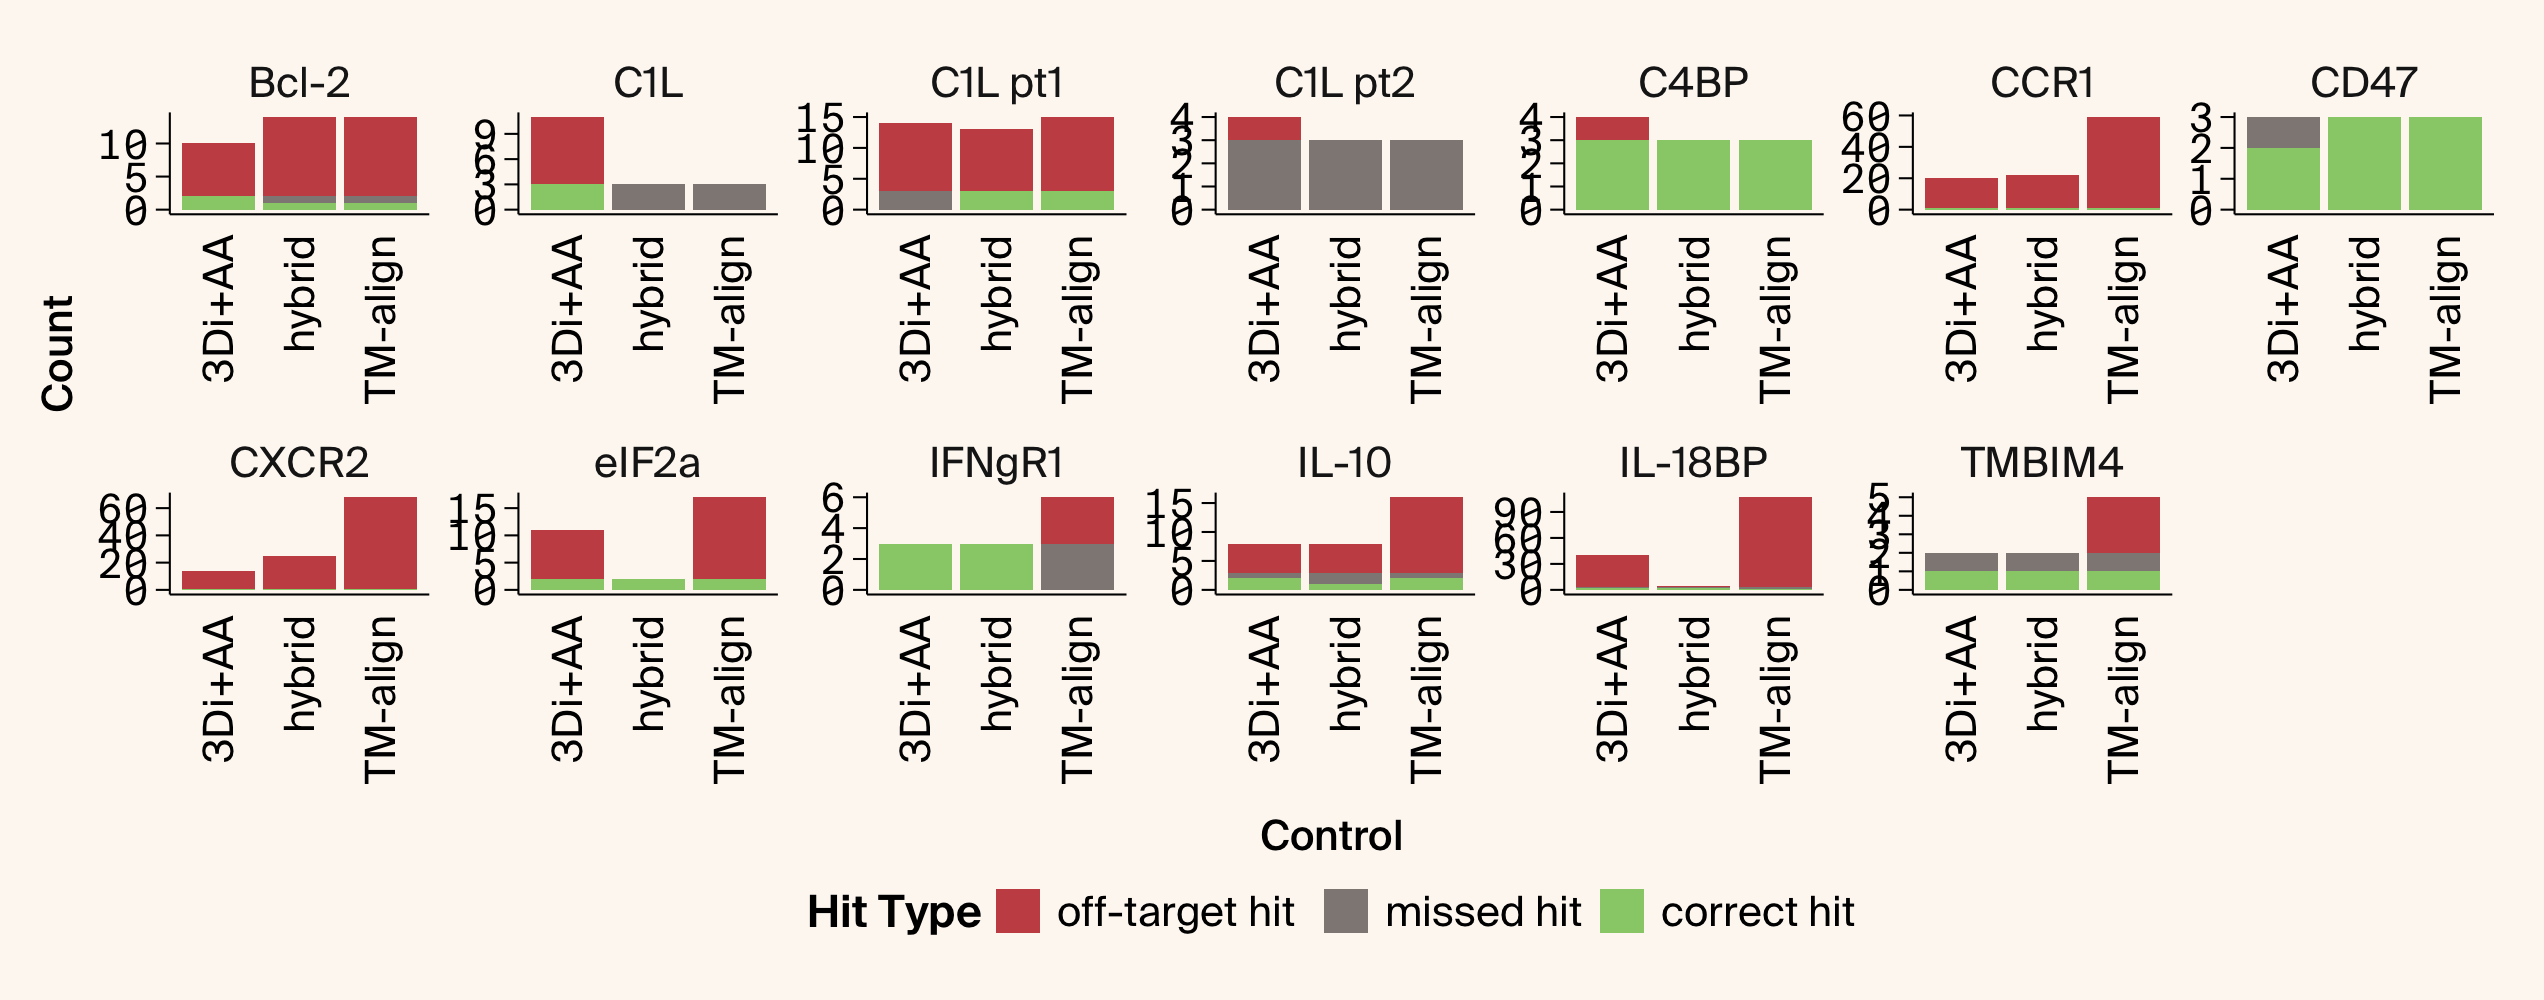

In [16]:
ggplot(hit_counts_long %>% filter(hit_type != "unknown correct hit") %>%
         filter(!plot_names %in% c("Chemokine", "Helicase", "Kinase", "Protease", 
                                   "RNA methylase")) %>%
         mutate(hit_type = factor(hit_type, levels = c("off-target hit", "missed hit", "correct hit"))),
       aes(x = model_type, y = count, fill = hit_type)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_wrap(~plot_names, ncol=7, scales = "free") +
  theme_arcadia(x_axis_type = "categorical") +
  labs(x = "Control", y = "Count", fill = "Hit Type") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        strip.text = element_text(family = CATEGORICAL_FONT, size = 15),
        strip.text.y = element_text(angle = 0), 
        legend.position = "bottom") +
  scale_fill_manual(values = c(DRAGON, BARK, LIME))

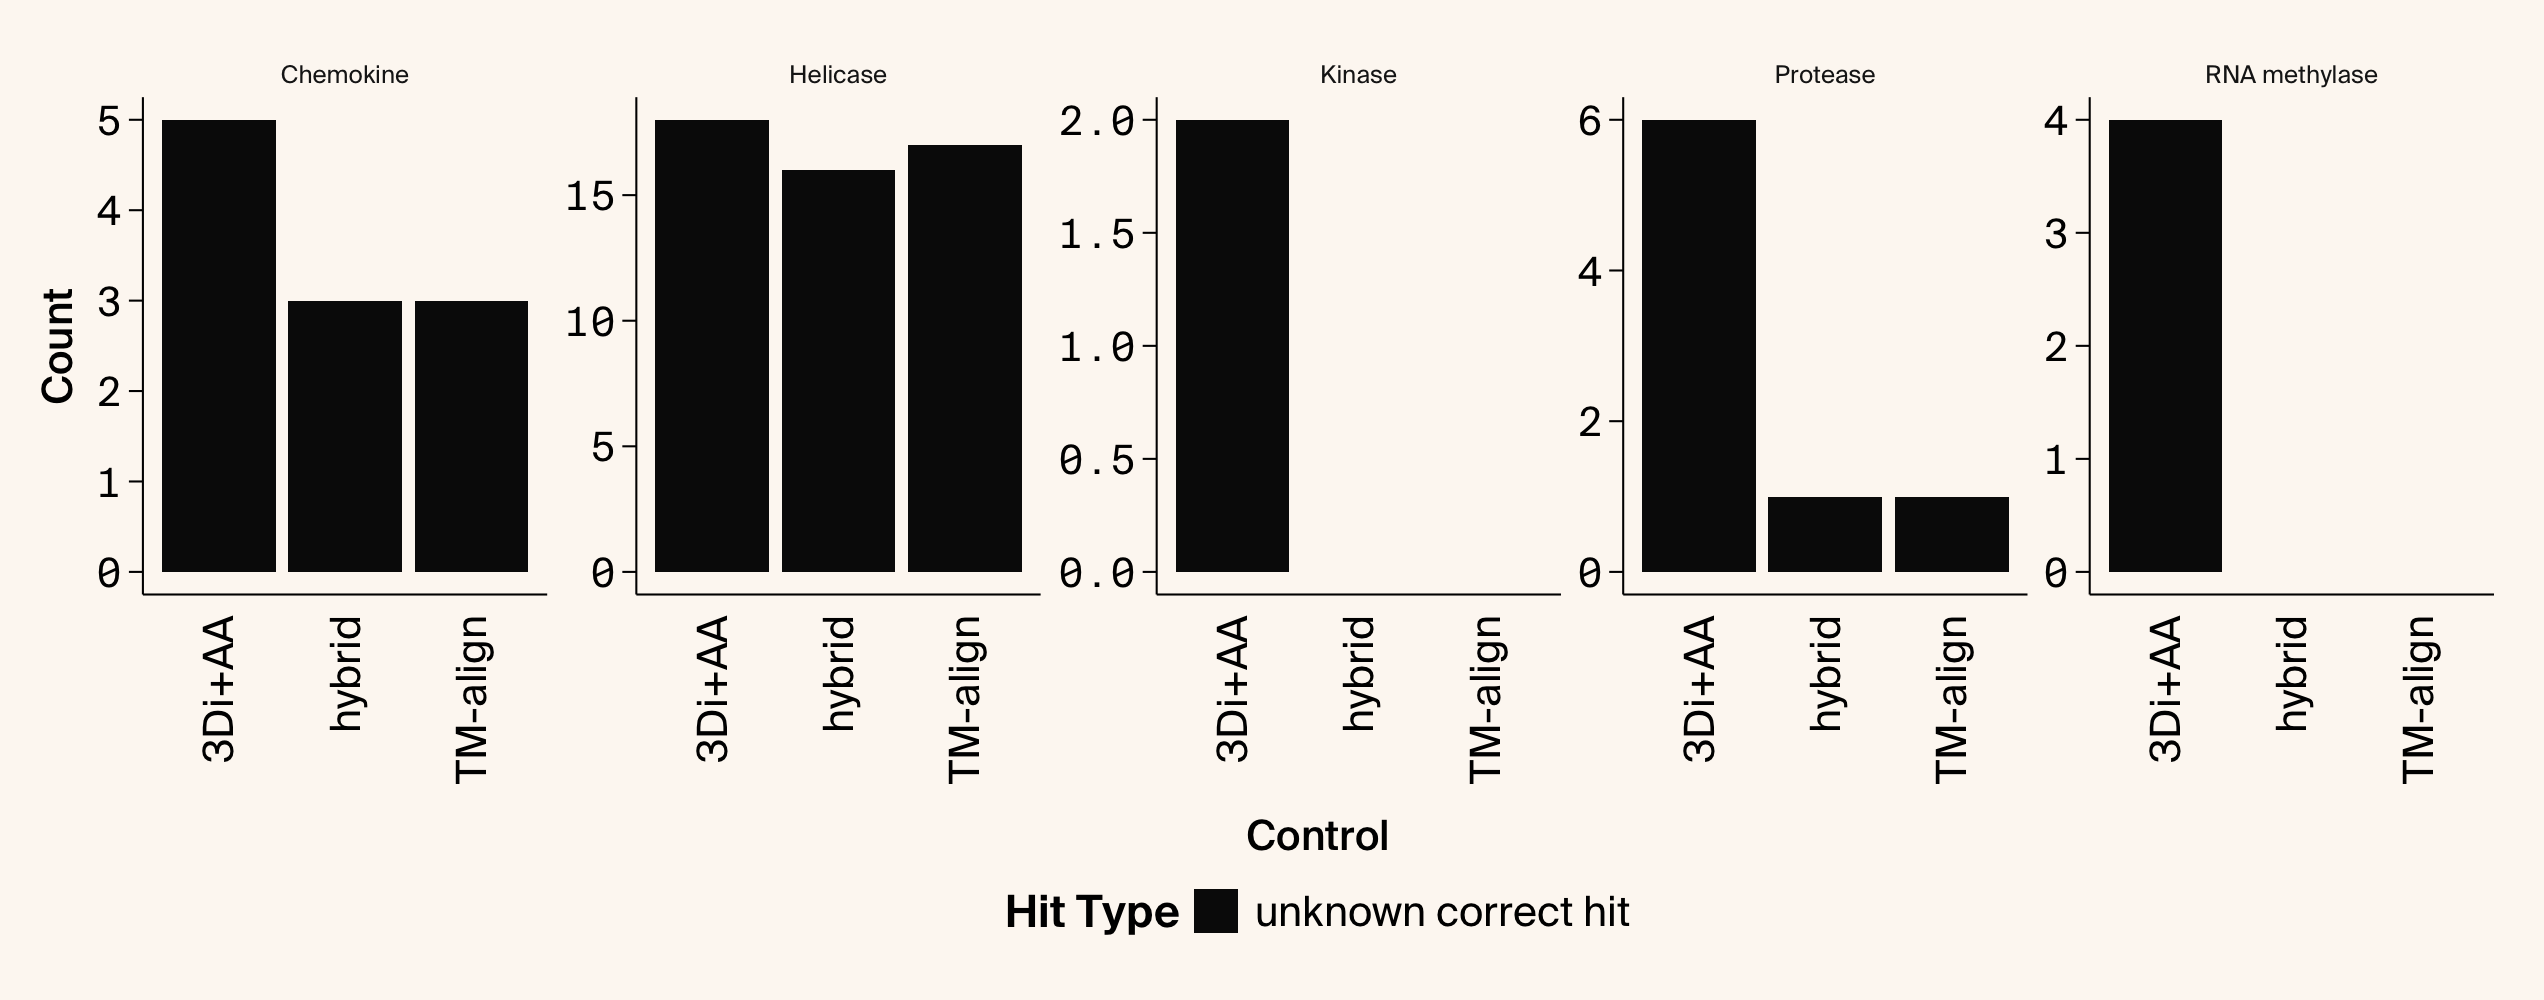

In [17]:
ggplot(hit_counts_long %>% filter(hit_type == "unknown correct hit") %>%
         filter(plot_names %in% c("Chemokine", "Helicase", "Kinase", "Protease", 
                                   "RNA methylase")),
       aes(x = model_type, y = count, fill = hit_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~plot_names, ncol=5, scales = "free_y") +
  theme_arcadia(x_axis_type = "categorical") +
  labs(x = "Control", y = "Count", fill = "Hit Type") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        strip.text = element_text(family = CATEGORICAL_FONT),
        strip.text.y = element_text(angle = 0), 
        legend.position = "bottom") +
  scale_fill_manual(values = c(BLACK))

In [18]:
sessionInfo()

R version 4.4.3 (2025-02-28)
Platform: x86_64-apple-darwin13.4.0
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.29.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] arcadiathemeR_0.1.0 lubridate_1.9.4     forcats_1.0.0      
 [4] stringr_1.5.1       dplyr_1.1.4         purrr_1.0.4        
 [7] readr_2.1.5         tidyr_1.3.1         tibble_3.2.1       
[10] ggplot2_3.5.2       tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] bit_4.6.0         gtable_0.3.6      jsonlite_2.0.0    compiler_4.4.3   
 [5] crayon_1.5.3      tidyselect_1.2.1  IRdisplay_1.1     parallel_4.4.3   
 [9] snakecase_0.11.1  scales_1.3.0      uuid_1.2-1      